
ReLU defense
==============================

**Author:** https://github.com/aliborji/ReLU_defense.git



In [ ]:
%matplotlib inline

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def test( model, device, test_loader, epsilon, do_seg = False):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        data_orig = torch.clone(data)

        # add noise
        # import pdb; pdb.set_trace()
        # data = add_noise(np.array(np.copy(data)))
        # data = torch.Tensor(data.tolist())
        # send to device
        data, target = data.to(device), target.to(device)        

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack_noise(data, epsilon, data_grad)
        
        # MULTIPLY THE ATTACK BY THE MASK; THAT IS REMOVE THE PERTURBATION ON BACKGROUND
        # import pdb; pdb.set_trace()
        if do_seg:
          mask = np.zeros_like(data_orig.detach())
          mask[data_orig.detach() > 0] = 1
          perturbed_data = perturbed_data.cpu().detach()* mask
          perturbed_data = perturbed_data.to(device)


        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
# pretrained_model = "/gdrive/My Drive/Tmp/lenet_mnist_model.pth"
# pretrained_model = '/gdrive/My Drive/Tmp/cifar_net.pth' #pretrained_model = "lenet_mnist_model.pth"
path = '/gdrive/My Drive/Tmp/slope_models/'
use_cuda=True

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


class FashionCNN(nn.Module):    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return F.log_softmax(out, dim=1)


train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=True)

# # MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=100, shuffle=True)

# # Define what device we are using
# print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")


# model = Net().to(device)  # training with slope 1 for now
model = FashionCNN().to(device)  # training with slope 1 for now



Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!





/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


# training a model first

In [ ]:
from torchsummary import summary
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# vgg = models.vgg16().to(device)
summary(model, (1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
              ReLU-3           [-1, 32, 28, 28]               0
         MaxPool2d-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 12, 12]          18,496
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
         MaxPool2d-8             [-1, 64, 6, 6]               0
            Linear-9                  [-1, 600]       1,383,000
        Dropout2d-10                  [-1, 600]               0
           Linear-11                  [-1, 120]          72,120
           Linear-12                   [-1, 10]           1,210
Total params: 1,475,338
Trainable params: 1,475,338
Non-trainable params: 0
---------------------------

In [ ]:
def add_noise(data):
  mask = data > 0

  # noise_data = np.random.rand(data.shape[0], data.shape[1], data.shape[2], data.shape[3])
  noise_data = np.random.rand(*data.shape)  
  noise_data[mask] = data[mask]

  return noise_data

In [ ]:
dd = iter(test_loader)
d, label = next(dd)

In [ ]:
type(d)

torch.Tensor

In [ ]:
data = np.array(d)

In [ ]:
data.max()

1.0

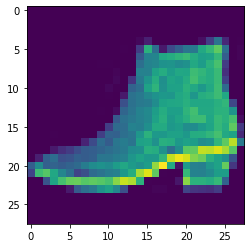

In [ ]:
plt.imshow(d[45,0])
plt.show()

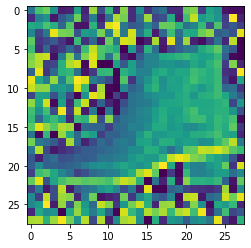

In [ ]:
xx = add_noise(data)
plt.imshow(xx[45,0])
plt.show()

In [ ]:
np.random.rand((d[0][0].shape).tolist())

AttributeError: ignored

In [ ]:
(d[0][0].shape)

torch.Size([1, 28, 28])

In [ ]:
del model

In [ ]:
EPOCHS = 10
losses = []

optimizer = optim.Adadelta(model.parameters(), lr=(1e-3))


model.train()
for epoch in range(EPOCHS):
    for batch_idx, (data, target) in enumerate(train_loader):

        # add noise
        # import pdb; pdb.set_trace()
        data = add_noise(np.array(np.copy(data)))
        data = torch.Tensor(data.tolist())

        # send to device
        data, target = data.to(device), target.to(device)        


        # Init
        optimizer.zero_grad()

        # Predict
        y_pred = model(data) 

        # Calculate loss
        
        # loss = F.cross_entropy(y_pred, target)
        loss = F.nll_loss(y_pred, target)        
        losses.append(loss.cpu().data)
#         losses.append(loss.cpu().data[0])        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(data), 
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.cpu().data), 
                end='')
    # Eval
    evaluate_x = test_loader.dataset.data.type_as(torch.FloatTensor())
    evaluate_x = evaluate_x / 255.
    evaluate_y = test_loader.dataset.targets

    evaluate_x, evaluate_y = evaluate_x.to(device), evaluate_y.to(device)        


    model.eval()
    output = model(evaluate_x[:,None,...])
    pred = output.data.max(1)[1]
    d = pred.eq(evaluate_y.data).cpu()
    accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]
    
    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Test Accuracy: {:.4f}%'.format(
        epoch+1,
        EPOCHS,
        len(train_loader.dataset), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.cpu().data,
        accuracy*100,
        end=''))
    

    

 Train Epoch: 1/10 [60000/60000 (100%)]	Loss: 0.423127	 Test Accuracy: 78.8200%
 Train Epoch: 2/10 [60000/60000 (100%)]	Loss: 0.485913	 Test Accuracy: 79.3800%
 Train Epoch: 3/10 [60000/60000 (100%)]	Loss: 0.279027	 Test Accuracy: 79.4600%
 Train Epoch: 4/10 [60000/60000 (100%)]	Loss: 0.318019	 Test Accuracy: 78.9200%
 Train Epoch: 5/10 [60000/60000 (100%)]	Loss: 0.437469	 Test Accuracy: 78.7400%
 Train Epoch: 6/10 [60000/60000 (100%)]	Loss: 0.398481	 Test Accuracy: 78.6000%
 Train Epoch: 7/10 [60000/60000 (100%)]	Loss: 0.486434	 Test Accuracy: 78.9000%
 Train Epoch: 8/10 [60000/60000 (100%)]	Loss: 0.308030	 Test Accuracy: 78.7400%
 Train Epoch: 9/10 [60000/60000 (100%)]	Loss: 0.402814	 Test Accuracy: 78.6100%
 Train Epoch: 10/10 [60000/60000 (100%)]	Loss: 0.308183	 Test Accuracy: 78.8400%


In [ ]:
# torch.save(model.state_dict(), path+'model_noise_fashionMNIST_noise.pth')


In [ ]:
model = FashionCNN().to(device)
model.load_state_dict(torch.load(path+'model_noise_fashionMNIST_clean.pth', map_location='cpu'))
# model = torch.load(path+'model_noise_fashionMNIST_noise.pth')

<All keys matched successfully>

In [ ]:
evaluate_x = test_loader.dataset.data.type_as(torch.FloatTensor())
evaluate_x = evaluate_x / 255.0
evaluate_y = test_loader.dataset.targets.type_as(torch.FloatTensor())

# evaluate_x = add_noise(np.array(evaluate_x)) # [:,None,...])))
# evaluate_x = torch.Tensor(evaluate_x)

evaluate_x, evaluate_y = evaluate_x.to(device), evaluate_y.to(device)        

model.eval()
output = model(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)

Accuracy: tensor(90.1300, dtype=torch.float64)


In [ ]:
evaluate_x.max()

tensor(255, device='cuda:0', dtype=torch.uint8)

On clean data

In [ ]:
evaluate_x = test_loader.dataset.data#.type_as(torch.FloatTensor())
evaluate_x = evaluate_x / 255.0
evaluate_y = test_loader.dataset.targets#.type_as(torch.FloatTensor())

evaluate_x, evaluate_y = evaluate_x.to(device), evaluate_y.to(device)        

model.eval()
output = model(evaluate_x[:,None,...])
pred = output.data.max(1)[1]
d = pred.eq(evaluate_y.data).cpu()
accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

print('Accuracy:', accuracy*100)

Accuracy: tensor(82.8200, dtype=torch.float64)


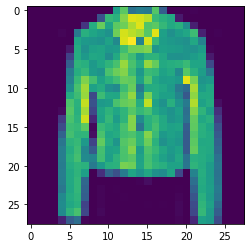

In [ ]:
plt.imshow(evaluate_x[10].cpu()); plt.show()

In [ ]:
mask.shape

NameError: ignored

In [ ]:
# FGSM attack code
def fgsm_attack_noise(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    # sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image

    noise = torch.rand_like(image)*2 - 1
    noise = noise.sign()
    
    # sample_noise = (sample_noise - sample_noise.min()) / (sample_noise.max() - sample_noise.min()) 


    perturbed_image = image + epsilon*noise
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

# Now perform adversarial attack

In [ ]:
test_loader_new = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)


accuracies = []
examples = []
accuracies_orig = []
examples_orig = []


# epsilons = [.2, .25, .3]

# Run test for each epsilon
for eps in epsilons:
    # do_seg = True
    # acc, ex = test(model, device, test_loader_new, eps, do_seg)
    # accuracies.append(acc)
    # examples.append(ex)

    do_seg = False
    acc_orig, ex_orig = test(model, device, test_loader_new, eps, do_seg)
    accuracies_orig.append(acc_orig)
    examples_orig.append(ex_orig)    

Epsilon: 0	Test Accuracy = 8252 / 10000 = 0.8252
Epsilon: 0.05	Test Accuracy = 8123 / 10000 = 0.8123
Epsilon: 0.1	Test Accuracy = 7904 / 10000 = 0.7904
Epsilon: 0.15	Test Accuracy = 7529 / 10000 = 0.7529
Epsilon: 0.2	Test Accuracy = 7067 / 10000 = 0.7067
Epsilon: 0.25	Test Accuracy = 6503 / 10000 = 0.6503
Epsilon: 0.3	Test Accuracy = 5925 / 10000 = 0.5925


In [ ]:
accuracies_orig

[0.8252, 0.8123, 0.7904, 0.7529, 0.7067, 0.6503, 0.5925]

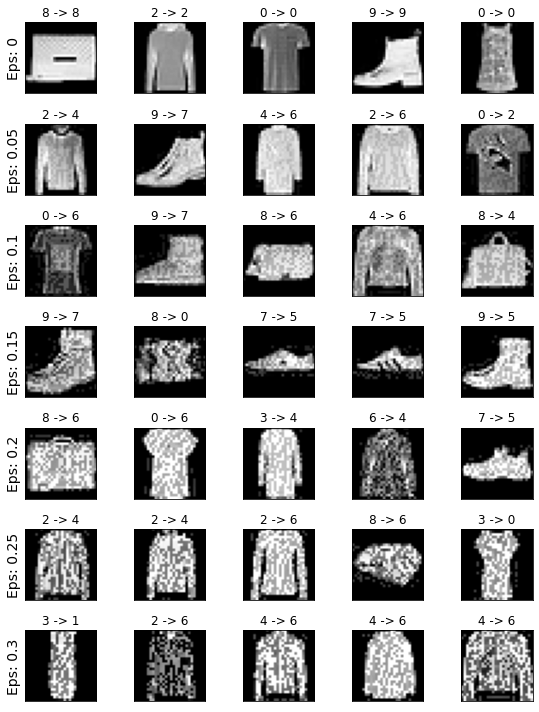

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

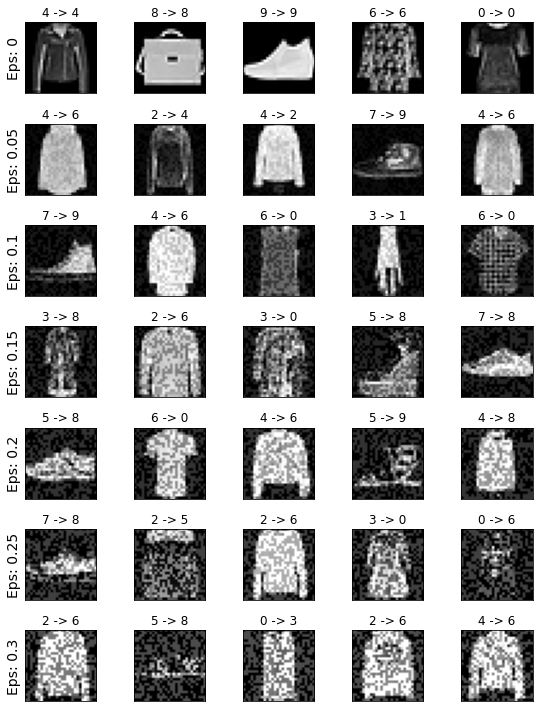

In [ ]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples_orig[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples_orig[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples_orig[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

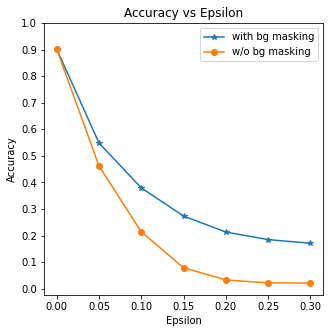

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.plot(epsilons, accuracies_orig, "o-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(['with bg masking', 'w/o bg masking'])
plt.show()

In [ ]:
accuracies

[0.9013, 0.5483, 0.3795, 0.2733, 0.2134, 0.1847, 0.1712]

In [ ]:
accuracies_orig

[0.9013, 0.4617, 0.2141, 0.0789, 0.0331, 0.022, 0.0211]

In [ ]:
accuracies = [0.764, 0.595, 0.4481, 0.355, 0.2706, 0.2101, 0.1646]
accuracies_orig = [0.8319, 0.1276, 0.0059, 0.0, 0.0001, 0.0, 0.0]
accuracies_clean = [0.9013, 0.5483, 0.3795, 0.2733, 0.2134, 0.1847, 0.1712]
accuracies_clean_orig = [0.9013, 0.4617, 0.2141, 0.0789, 0.0331, 0.022, 0.0211]

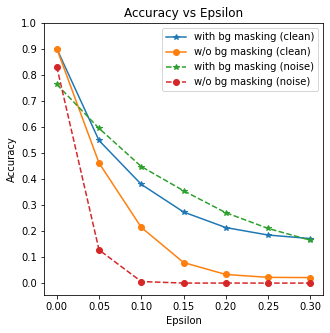

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies_clean, "*-")
plt.plot(epsilons, accuracies_clean_orig, "o-")
plt.plot(epsilons, accuracies, "*--")
plt.plot(epsilons, accuracies_orig, "o--")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.legend(['with bg masking (clean)', 'w/o bg masking (clean)', 'with bg masking (noise)', 'w/o bg masking (noise)']) #, loc='right top')
plt.show()